# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

Before you start this analysis, you'll need a new library you haven't installed before—Quandl. Install Quandl using conda:

`conda install quandl`

In [5]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

### 2.Creating a path 

In [8]:
path = r'/Users/ceciliamoura/Desktop/Career Foundry/Achievement 6/Analysis'

In [10]:
data = pd.read_csv(os.path.join (path, 'Original Data', 'insu_cov_4.csv'), index_col=False)

In [12]:
data.head(5)

,Year,United States,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,01-01-2023,92.1,91.5,89.6,90.1,91.1,93.6,93.3,94.3,93.5,...,91.7,90.7,83.6,92.0,96.6,93.6,93.7,94.1,95.1,89.3
1,01-01-2022,92.0,91.2,89.0,89.7,91.6,93.5,92.9,94.8,94.4,...,91.9,90.7,83.4,91.9,96.1,93.5,93.9,94.1,94.8,88.5
2,01-01-2021,91.4,90.1,88.6,89.3,90.8,93.0,92.0,94.8,94.3,...,90.5,90.0,82.0,91.0,96.3,93.2,93.6,93.9,94.6,87.8
3,01-01-2020,91.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01-01-2019,90.8,90.3,87.8,88.7,90.9,92.3,92.0,94.1,93.4,...,89.8,89.9,81.6,90.3,95.5,92.1,93.4,93.3,94.3,87.7


#### <mark>The original dataset has the following columns. One for YEAR (2008-2023, except for 2020), columns with the value of PERCENTAGE OF THE POPULATION WITH ANY HEALTHCARE COVERAGE for United States and for each State individually. I added the mean value for Year 2020, to be able to proceed with the analysis<mark>


In [15]:
data.shape

(16, 53)

In [17]:
data.columns

Index(['Year', 'United States', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='object')

In [19]:
type(data)

pandas.core.frame.DataFrame

### 3. Creating a subset with only 'Year' and 'United States'

In [22]:
data_sub = data[['Year', 'United States']]
# the values under 'United States' refer to the percentage of the population with any health insurance

In [24]:
data_sub.head()

,Year,United States
0,01-01-2023,92.1
1,01-01-2022,92.0
2,01-01-2021,91.4
3,01-01-2020,91.4
4,01-01-2019,90.8


In [26]:
# Setting the date as the index


In [28]:

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Year']) #Create a datetime column from 'Year'
data_sub = data_sub.set_index('datetime') # set the datetime as the index of the dataframe
data_sub.drop(['Year'], axis=1, inplace=True) #drop the 'Year' column
data_sub.head()

,United States
datetime,
2023-01-01,92.1
2022-01-01,92.0
2021-01-01,91.4
2020-01-01,91.4
2019-01-01,90.8


In [30]:
len(data_sub)

16

In [32]:
data_sub.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16 entries, 2023-01-01 to 2008-01-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   United States  16 non-null     float64
dtypes: float64(1)
memory usage: 256.0 bytes


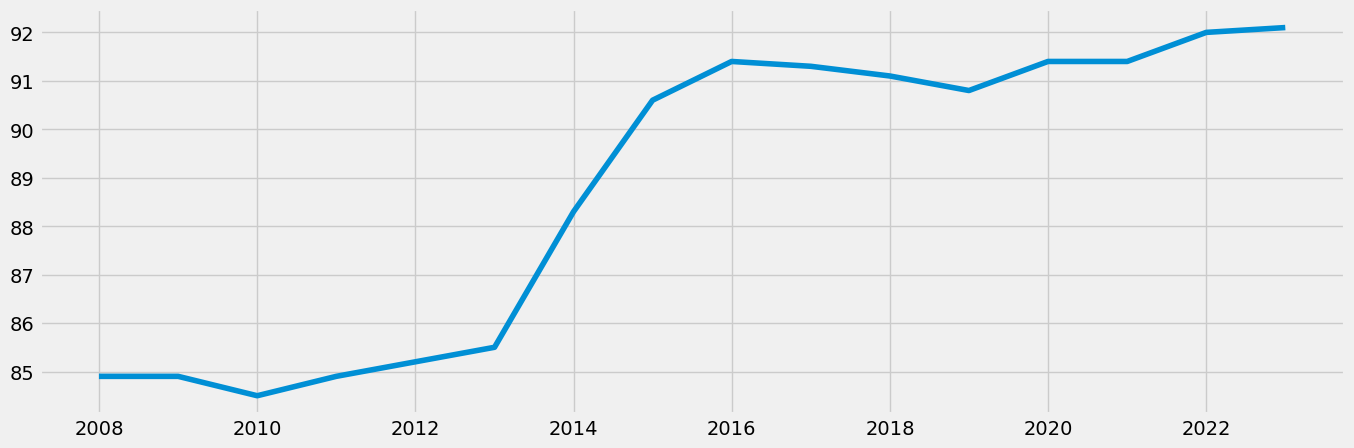

In [34]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data_sub)

### 4. Cleaning time-series data

In [37]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

United States    0
dtype: int64

### 5. Time-series analysis: decomposition

In [40]:
print(data_sub.index)  # Print the index values

DatetimeIndex(['2023-01-01', '2022-01-01', '2021-01-01', '2020-01-01',
               '2019-01-01', '2018-01-01', '2017-01-01', '2016-01-01',
               '2015-01-01', '2014-01-01', '2013-01-01', '2012-01-01',
               '2011-01-01', '2010-01-01', '2009-01-01', '2008-01-01'],
              dtype='datetime64[ns]', name='datetime', freq=None)


In [42]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive', period=1)  # 1 year

In [44]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

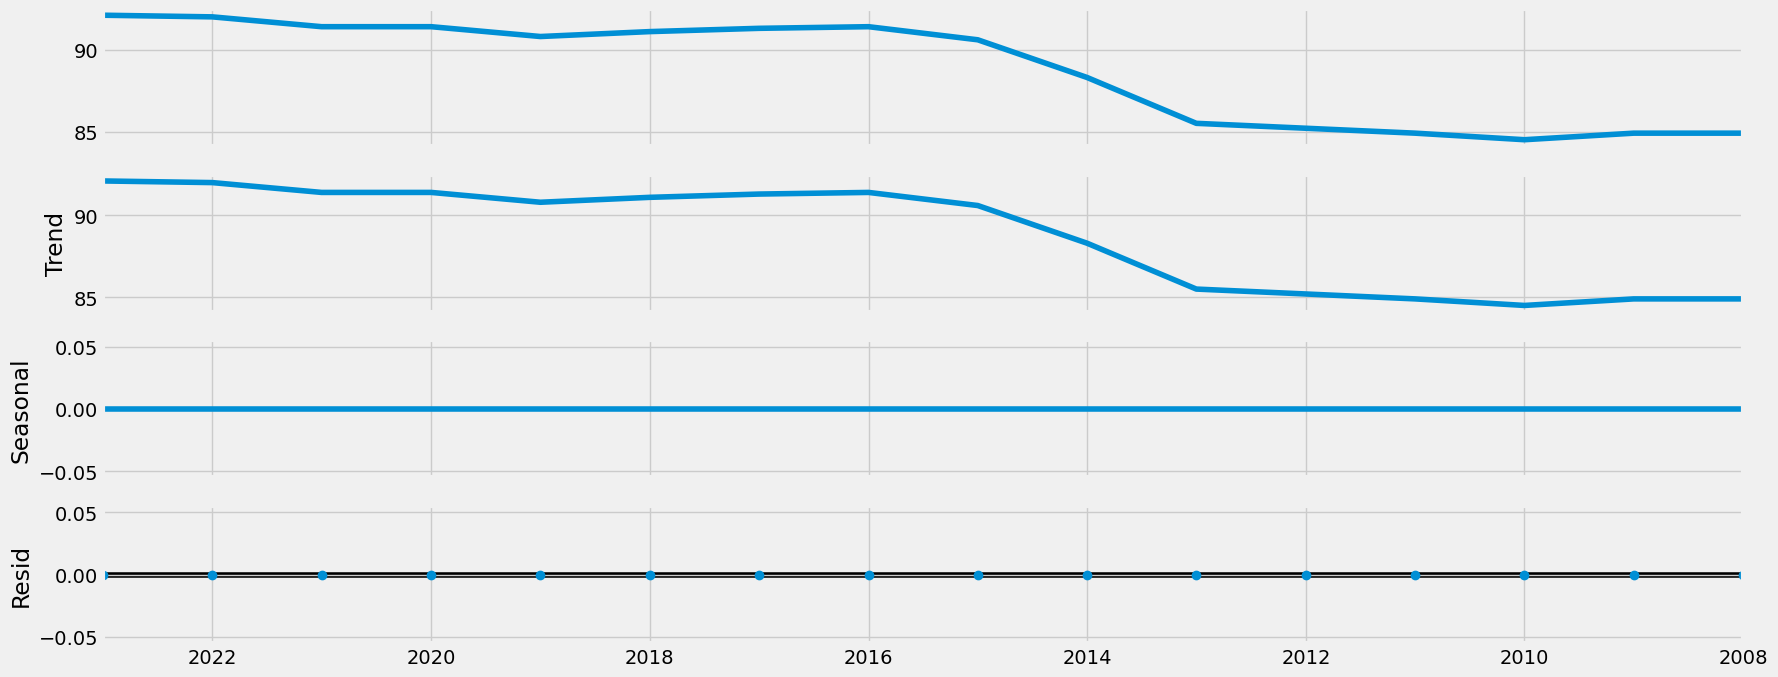

In [46]:
# Plot the separate components

decomposition.plot()
plt.show()

### 5. Testing for stationarity

In [49]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['United States'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.048940
p-value                         0.734999
Number of Lags Used             1.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64


### <mark>Null hypothesis = there is a unit root | Alternative hypothesis = there is no unit root<mark>

In [52]:
# The test statistic of -1.04 > critical value (5% = -3.1), so I can't reject the null hypothesis

### <mark> I Can't reject the Null Hypothesis<mark>, There is a unit root in my data

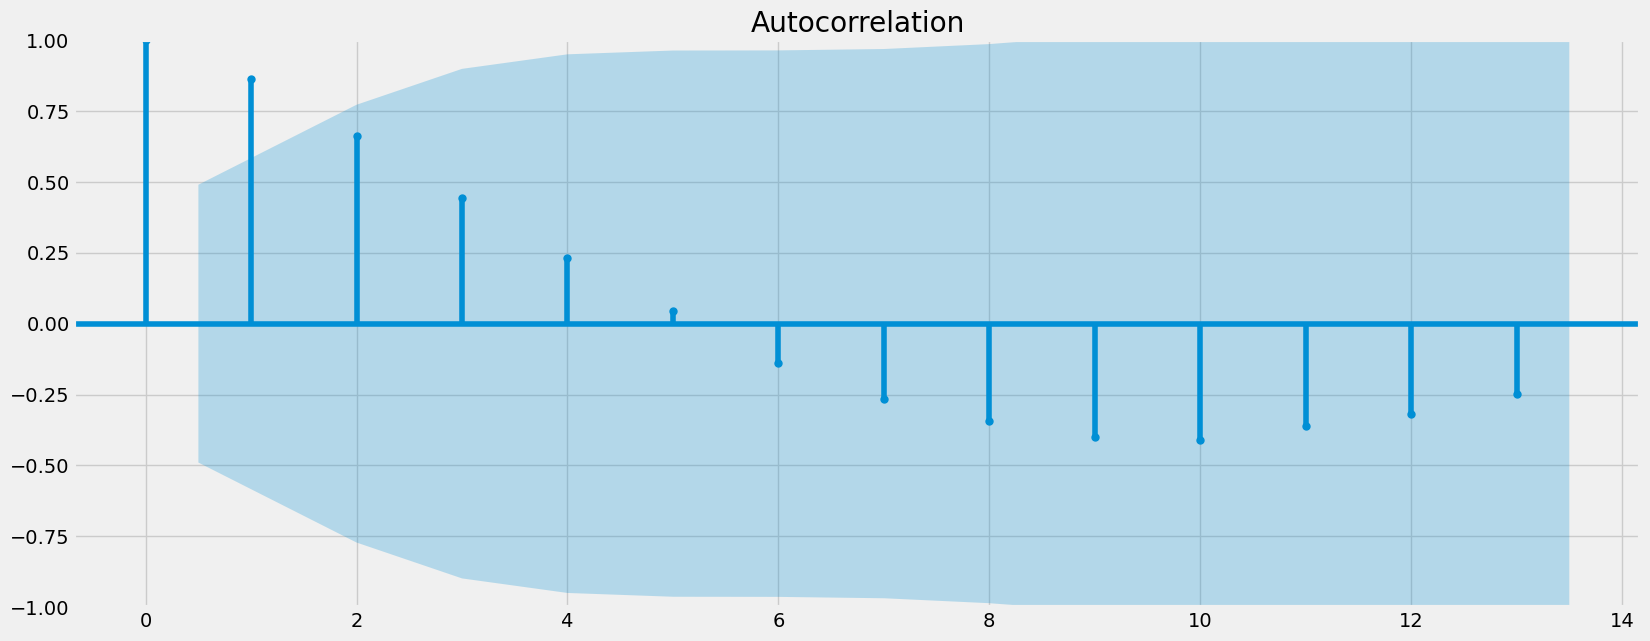

In [55]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### 6. Stationarizing the National Health Insurance Coverage Data

In [58]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [60]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [62]:
data_diff.head()

,United States
datetime,
2022-01-01,-0.1
2021-01-01,-0.6
2020-01-01,0.0
2019-01-01,-0.6
2018-01-01,0.3


In [64]:
data_diff.columns

Index(['United States'], dtype='object')

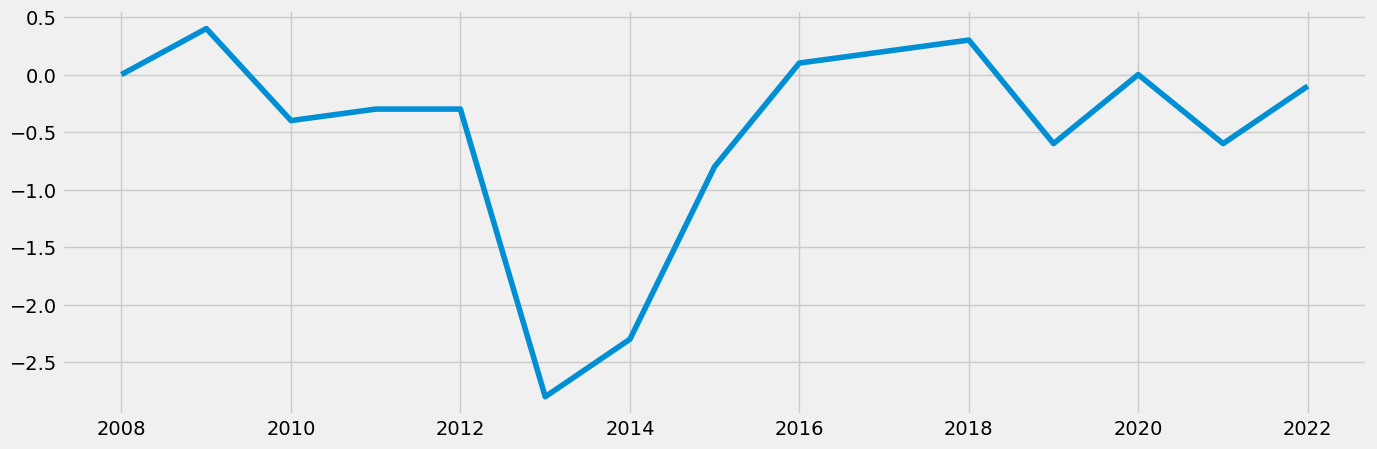

In [66]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [68]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -2.063966
p-value                         0.259249
Number of Lags Used             0.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64


In [70]:
# The test statistic of -2.06 > critical value (5% = -3.1), so I still can't reject the null hypothesis

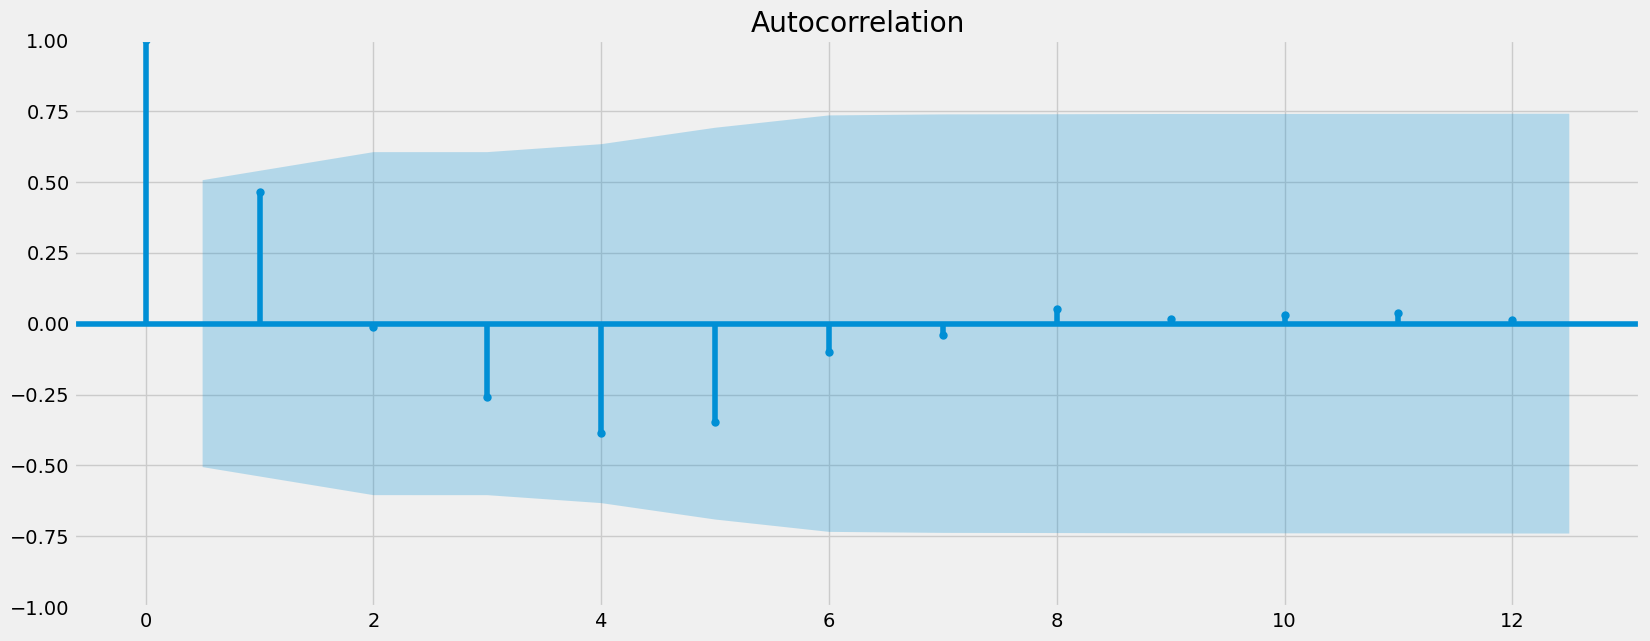

In [72]:
plot_acf(data_diff)
plt.show()

In [74]:
# I will repeat the process to try stationarizing the data

In [76]:
data_diff2 = data_diff - data_diff.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [78]:
data_diff2.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [80]:
data_diff2.head()

,United States
datetime,
2021-01-01,-0.5
2020-01-01,0.6
2019-01-01,-0.6
2018-01-01,0.9
2017-01-01,-0.1


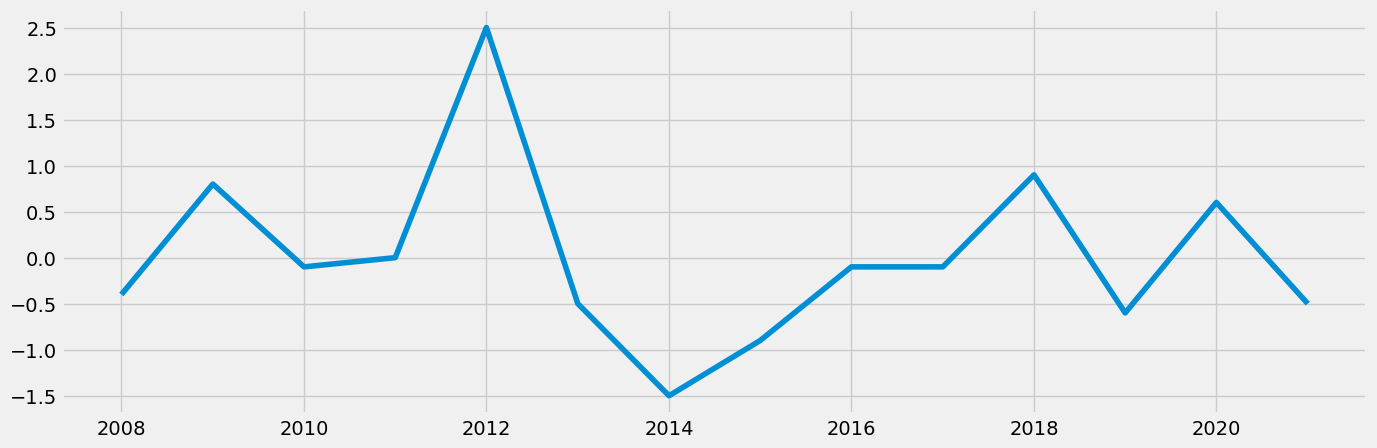

In [87]:
# Check out what re running the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [85]:
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.549518
p-value                         0.006803
Number of Lags Used             0.000000
Number of Observations Used    13.000000
Critical Value (1%)            -4.068854
Critical Value (5%)            -3.127149
Critical Value (10%)           -2.701730
dtype: float64


In [89]:
# The test statistic of -3.5 < critical value (5% = -3.1), so I can now reject the null hypothesis

### <mark>The data_diff2 is stationary enough <mark>

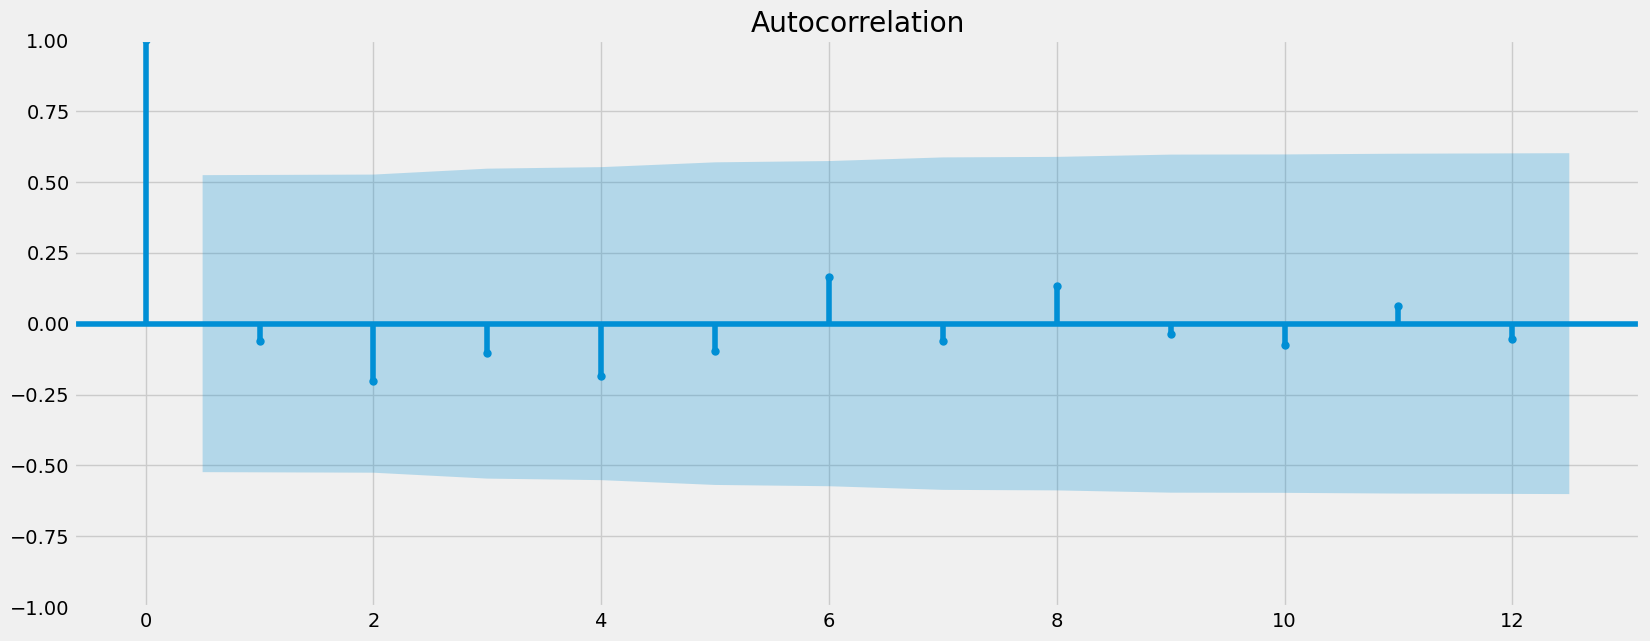

In [93]:
plot_acf(data_diff2)
plt.show()